In [1]:
import os

import basd
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
import pandas as pd
import scipy.stats as sps
import seaborn as sns
import xarray as xr

### Exploring the `xarray` package

   - Creating two `DataArray`s, affectively dataframes with extra attributes
        - One for precipitation and one for temperature at 4 grid cells
   - Adding these two `DataArray`s to a `Dataset`, more or less a dictionary for these data

In [2]:
# Precipitation data array
pr = xr.DataArray( np.random.rand(2,2), dims=('lat','lon'), coords={'lat':[35,10]})
pr.attrs['long_name'] = 'precipitation'
pr.attrs['units'] = 'inches'
pr.attrs['description'] = 'mean precipitation of grid cell, daily'

# Temperature data array
tas = xr.DataArray( np.random.rand(2,2), dims=('lat','lon'), coords={'lat':[35,10]})
tas.attrs['long_name'] = 'precipitation'
tas.attrs['units'] = 'inches'
tas.attrs['description'] = 'mean precipitation of grid cell, daily'

# Dataset of the two above data arrays
dataset = xr.Dataset(dict(pr=pr, tas=tas))

#### Reading in a NetCDF file

Reading in observational precipitation data from 1979-2014 supplied in the data directory.

In [3]:
pr_obs_hist = xr.open_dataset('../basd/data/pr_obs-hist_coarse_1979-2014.nc')
pr_sim_hist = xr.open_dataset('../basd/data/pr_sim-hist_coarse_1979-2014.nc')
pr_sim_fut = xr.open_dataset('../basd/data/pr_sim-fut_coarse_2065-2100.nc')

## Running a Bias Adjustment

### Initializing our first `Adjustment` object

Here we are providing the three required data arrays and the variable name 'pr'. For precipitation, a variable that will be bounded below, we want to input some additional parameters:

- Lower bound = 0
- Lower threshold = 0.001
- Trend preservation = mixed
- Distribution = gamma

Otherwise, we are keeping the default parameter values for the bias adjustment

In [4]:
params = basd.Parameters(lower_bound=0, lower_threshold=0.0000011574,
                         trend_preservation='mixed', distribution='gamma')
ba = basd.Adjustment(pr_obs_hist, pr_sim_hist, pr_sim_fut, 'pr', params)

#### Running Bias Adjustment
Here we run bias adjustment for just one grid cell. We pass in a tuple with the indexes which we wish to adjust, (0,0), which in this case correspond to lat 53.5 degrees and lon 12.5 degrees.

In [6]:
loc = tuple([0, 0])
sim_fut_ba_loc = ba.adjust_bias_one_location(loc)

#### Combining Results into Dataframe

In [25]:
sim_fut_loc = ba.sim_fut[ba.variable][loc]
sfba_df = sim_fut_loc.to_dataframe().reset_index()
sf_df = sim_fut_loc.to_dataframe().reset_index()
sfba_df['Source'] = 'Simulated Future Bias Adjusted'
sf_df['Source'] = 'Simulated Future'
plot_data = pd.concat([sf_df, sfba_df], ignore_index=True)

#### Visualizing Results

Text(0.5, 0, 'Precipitation (kg m^-2 s^-1)')

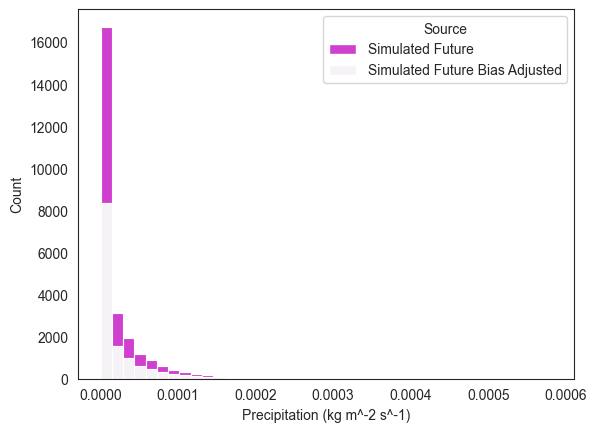

In [41]:
sns.set_style(style='white')
p = sns.histplot(data=plot_data, x = 'pr', hue = 'Source', bins = 40,
                 multiple='stack', palette="light:m_r" )
#p.set_yscale('log')
p.set_xlabel('Precipitation (kg m^-2 s^-1)')

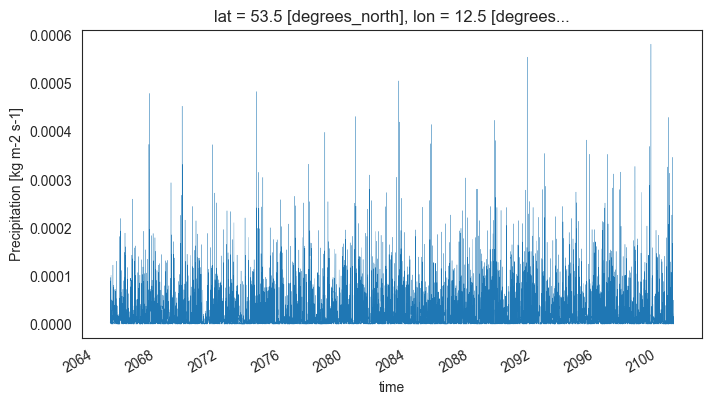

In [36]:
p1 = sim_fut_loc.plot.line(x='time', marker=None, linewidth=0.2, aspect=2, size=4)

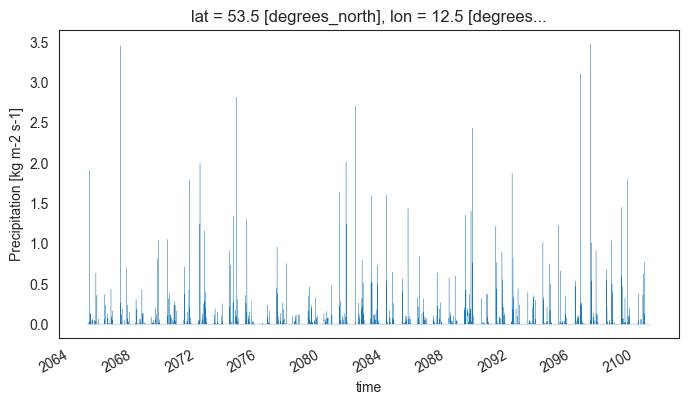

In [37]:
p2 = sim_fut_ba_loc.plot.line(x='time', marker=None, linewidth=0.2, aspect=2, size=4)